<img src="../../images/wt4.png" align="right" width="70"/>

  #     Notebook for early bearing fault detection for WT04



## Table of contents
1. Raw signal
2. Resampled signal
3. Filtered signal with optimal bandpass based on SK
4. Demodulasation using EEMD signals
5. Selecting IMF: Correlation coefficient
6. Envelope spectral analyis
7. Frequency study

In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys, os,os.path
import matplotlib.pyplot as plt

ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
module_paths = []
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/hybrid_analysis_process_functions/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/utils/")))
for module_path in module_paths:
    if module_path not in sys.path:
        print("appended")
        sys.path.append(module_path)
import functions as f
%autoreload
import wt_data, ff_transform, explore_fft_time_data, envelope, build_dataset, load_raw_signals, envelope, envelope_emd
import resample_signals, filter_signals, plotting_methods


appended
appended
appended
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
/Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src


## 1. Raw signal 

In [3]:
vib_signal, times, op_data_intervals, peak_array = load_raw_signals.load_raw('gearbox','wt04')
avg_rpm = np.asarray(op_data_intervals['AvgSpeed'])
avg_power = np.asarray(op_data_intervals['AvgPower'])

File exist


5
110886912


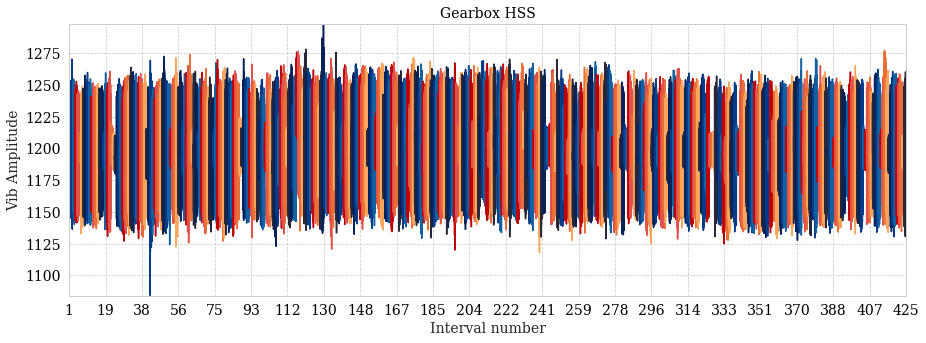

In [4]:
envelope.plot_vib_consecutive(vib_signal)

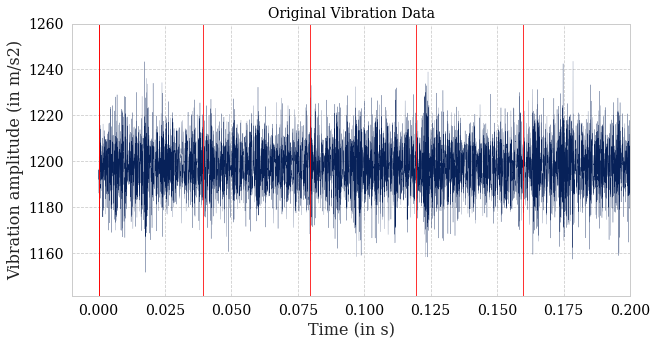

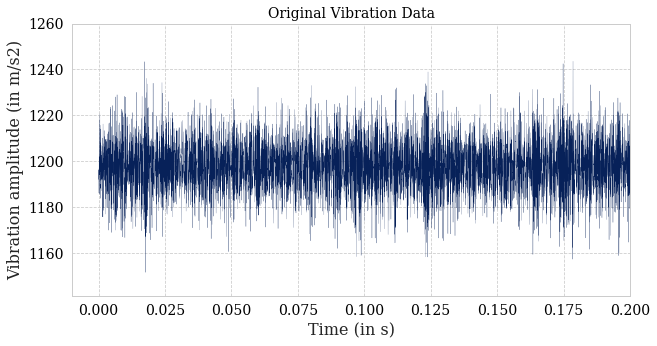

In [236]:
i=67
plotting_methods.plot_signal(times[i], vib_signal[i], peak_array=peak_array[i], x_min=-0.01, x_max=0.2, name='Original')
plotting_methods.plot_signal(times[i], vib_signal[i], x_min=-0.01, x_max=0.2, name='Original')

In [237]:
%autoreload
import plotting_methods

ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
/Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src


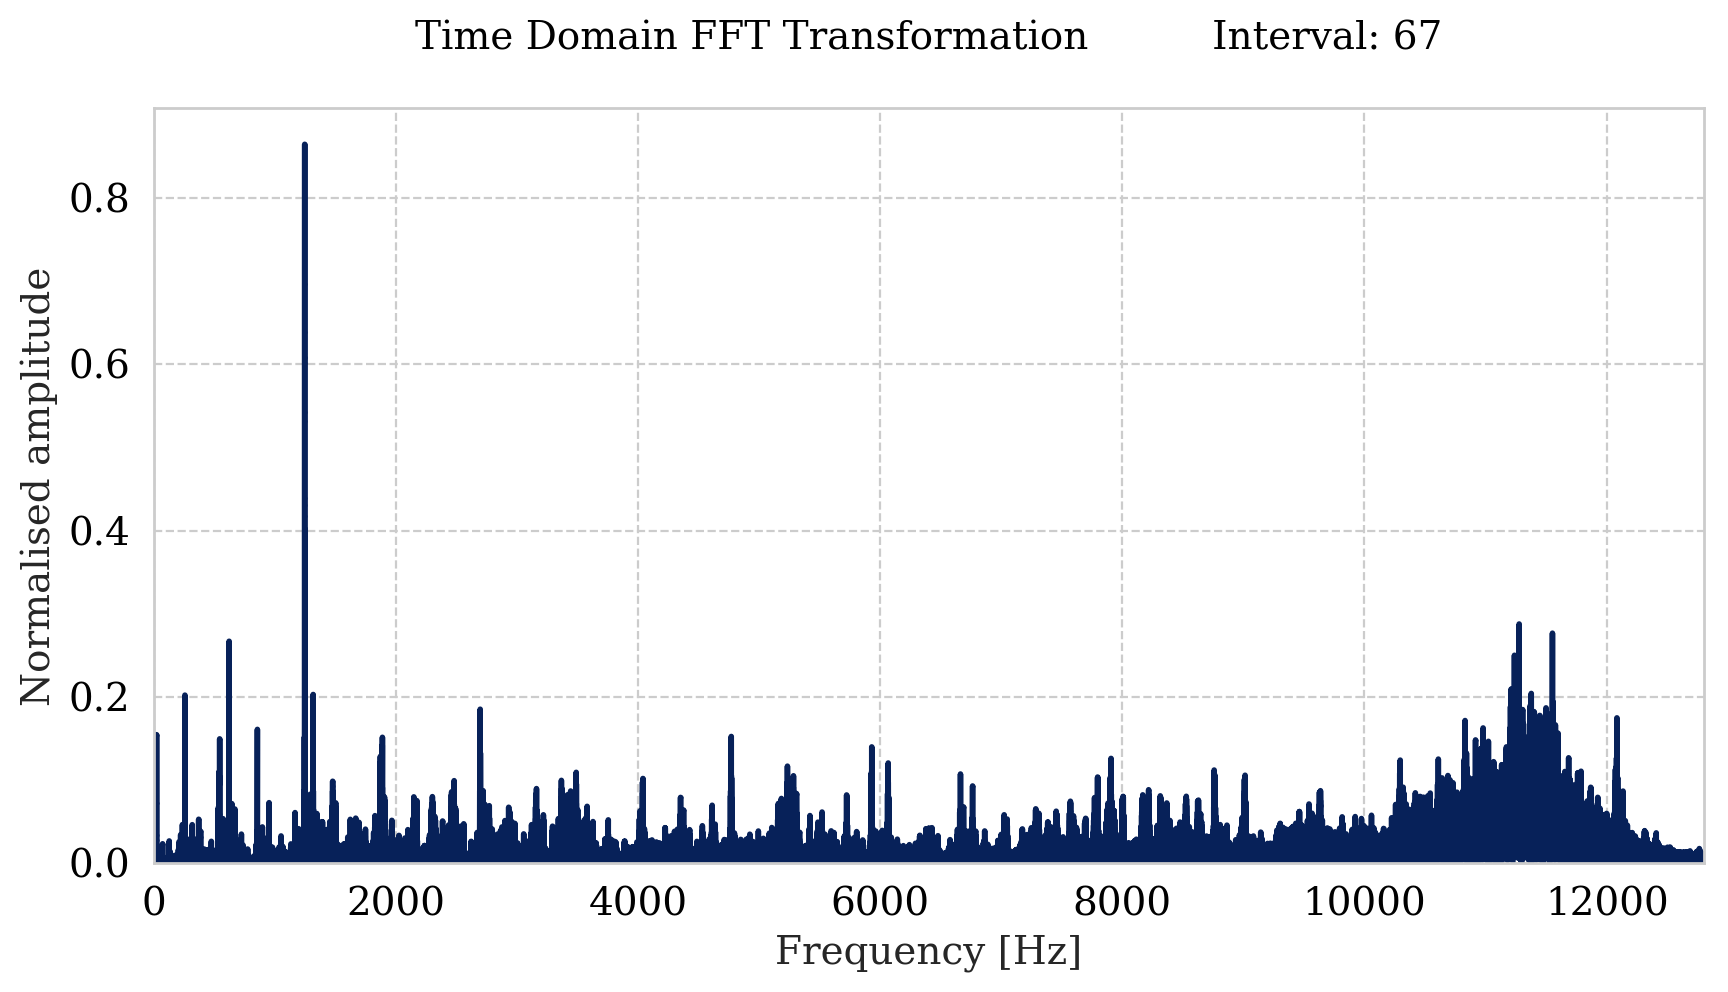

In [238]:

plotting_methods.plot_fft(times[i], vib_signal[i], interval_num=i)

### Filter out the first 2000Hz

In [218]:
low_cut = 2000
filtered_raw_vib = []
vib_signal_size = len(vib_signal)

for i, vib_sig in enumerate(vib_signal):
    flitered_vib_sig = filter_signals.do_high_pass_filter(vib_sig, low_cut)
    filtered_raw_vib.append(flitered_vib_sig)
    print(f'Filtered {i+1} / {vib_signal_size} signals', end='\r')
filtered_raw_vib = np.asarray(filtered_raw_vib)

### Plot FFT of raw and filtered raw for verification

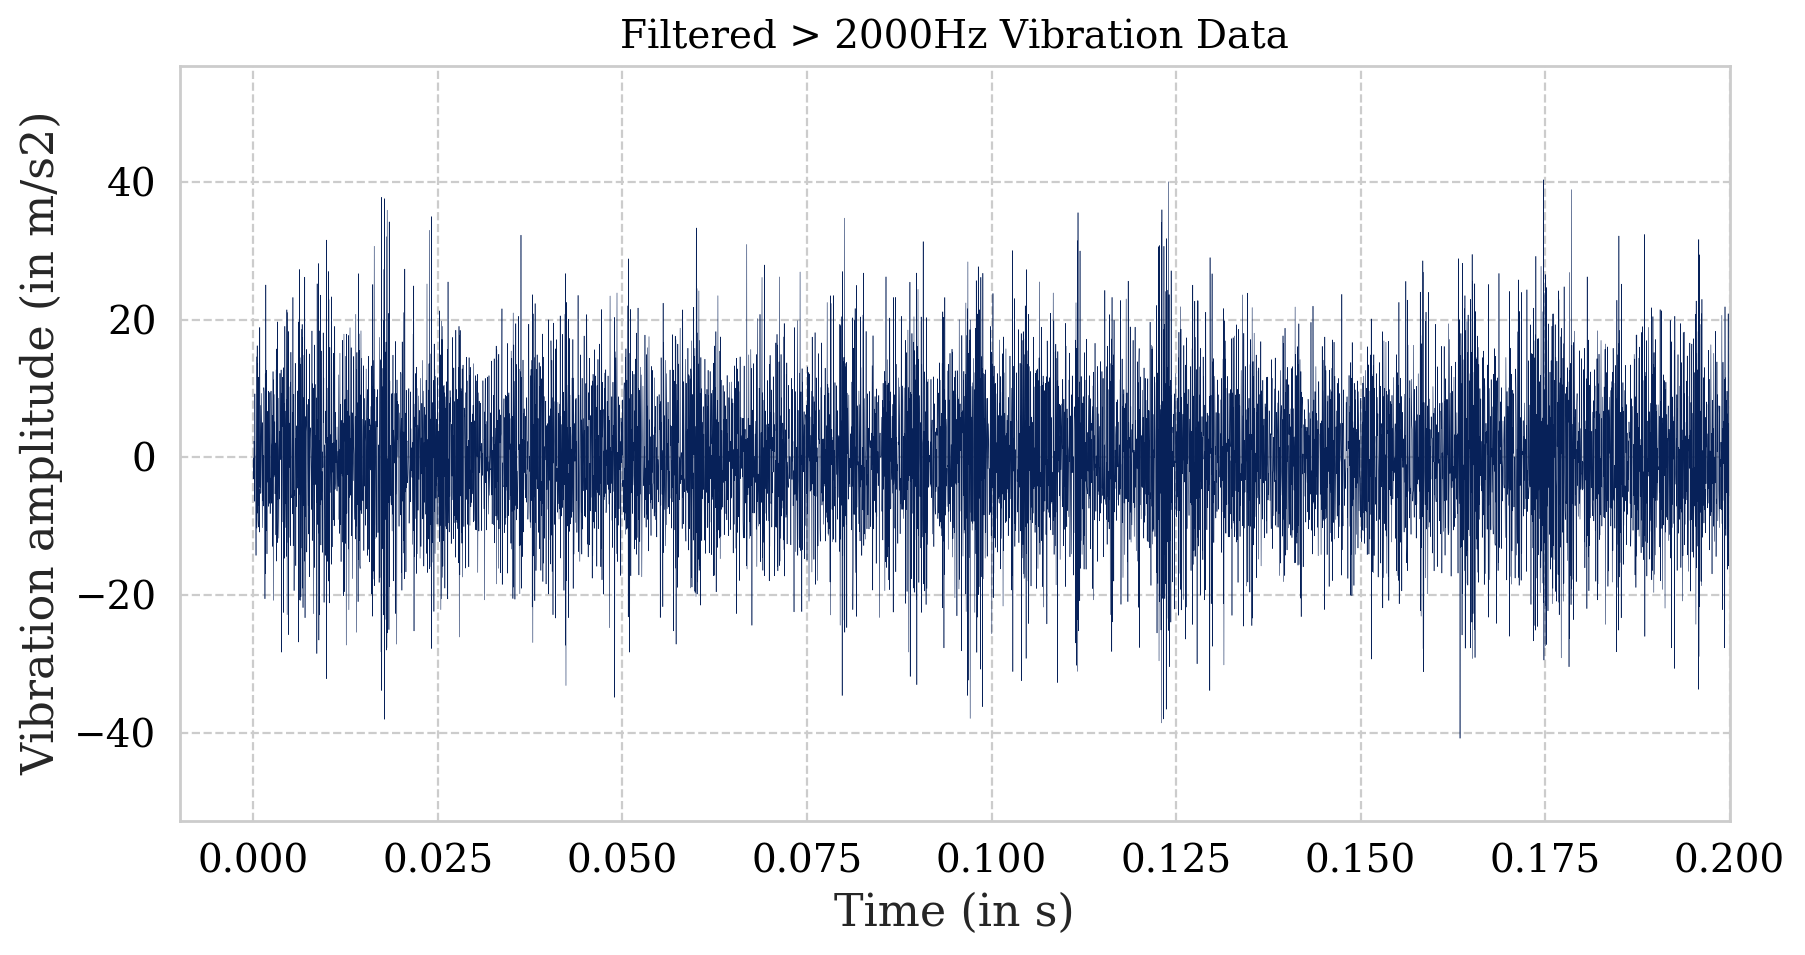

In [240]:
plotting_methods.plot_signal(times[i], filtered_raw_vib[i], x_min=-0.01, x_max=0.2, name='Filtered > 2000Hz')

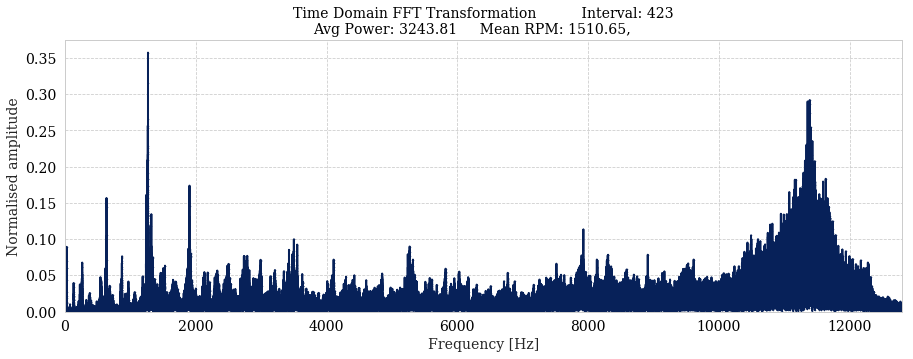

In [223]:

plotting_methods.plot_fft(times[i], vib_signal[i], avg_power=avg_power[i], avg_rpm=avg_rpm[i], interval_num=i)

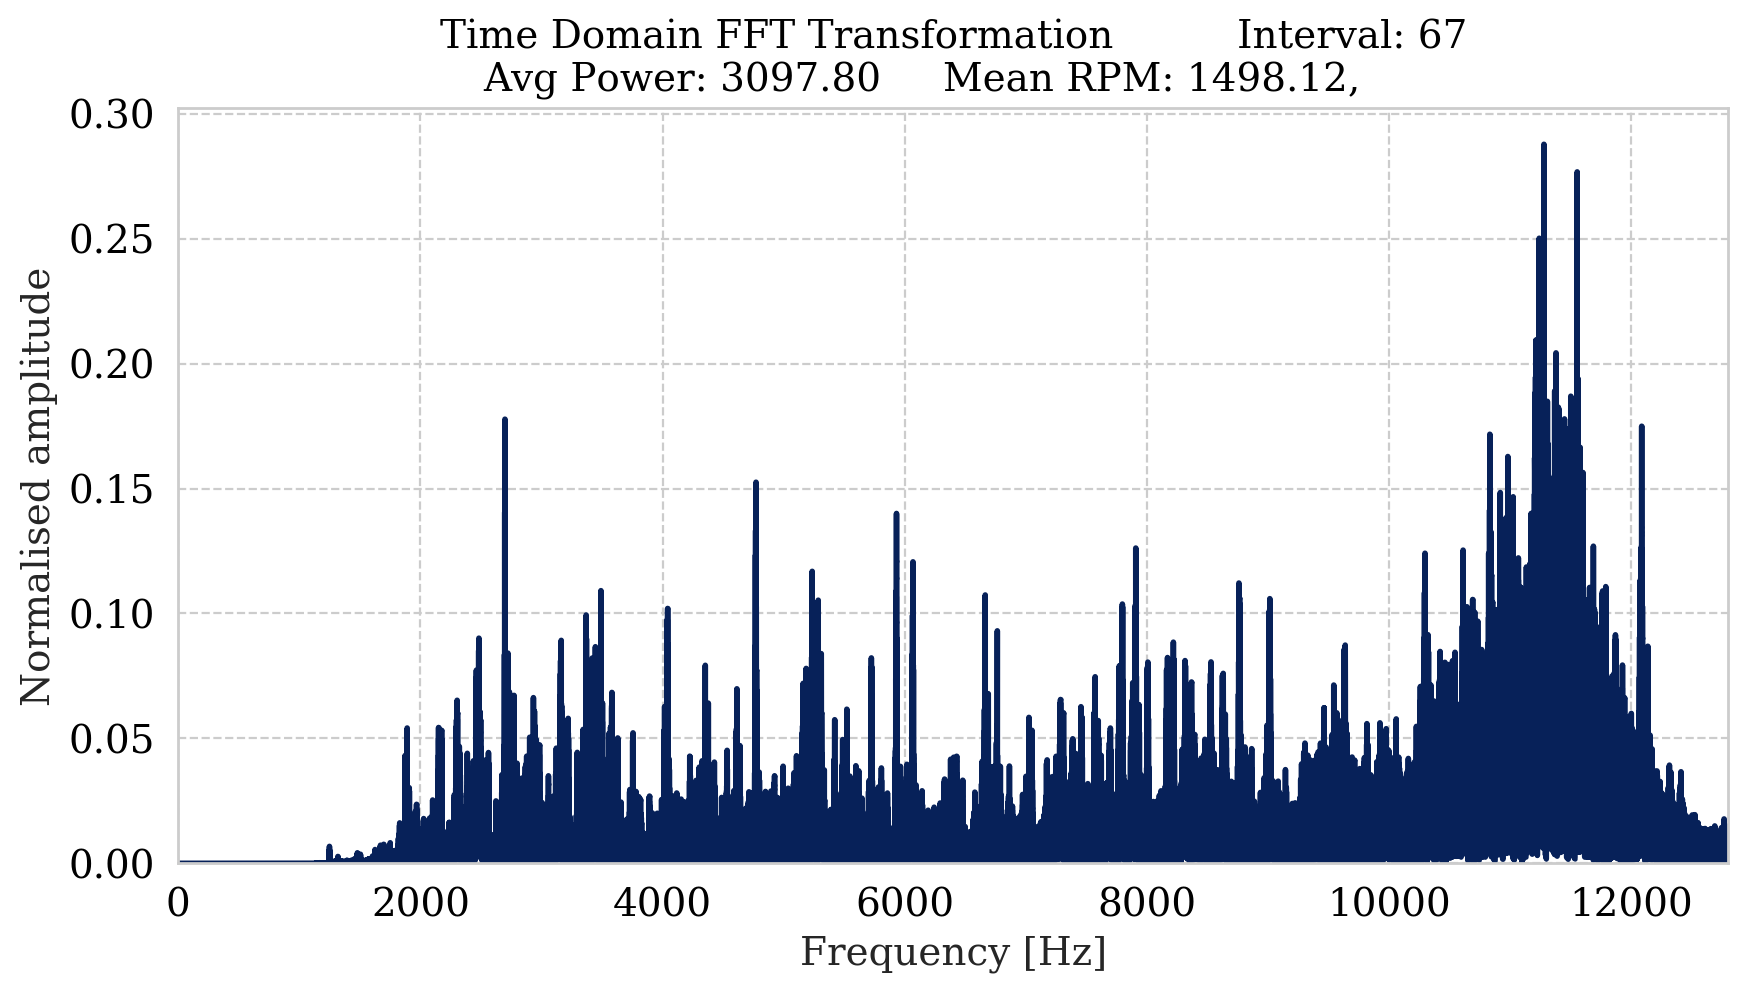

In [241]:

plotting_methods.plot_fft(times[i], filtered_raw_vib[i], avg_power=avg_power[i], avg_rpm=avg_rpm[i], interval_num=i)

#### Save filtered, raw vibration signal to CSV

In [ ]:
'''
path = '/Volumes/OsvikExtra/signal_data/raw_filtered_2000Hz/gearbox/wt04/';
list_size = len(filtered_raw_vib)
for i, vib_sig in enumerate(filtered_raw_vib):
    np.savetxt(f'{path}filtered_raw_{i}.csv', vib_sig, delimiter=',')
    print(f'Saved {i+1} / {list_size} files', end='\r')
'''

### Filter out the first 6000Hz

In [6]:
low_cut = 6000
filtered_raw_vib_6000 = []
vib_signal_size = len(vib_signal)

for i, vib_sig in enumerate(vib_signal):
    flitered_vib_sig = filter_signals.do_high_pass_filter(vib_sig, low_cut)
    filtered_raw_vib_6000.append(flitered_vib_sig)
    print(f'Filtered {i+1} / {vib_signal_size} signals', end='\r')
filtered_raw_vib_6000 = np.asarray(filtered_raw_vib_6000)

### Plot FFT of raw and filtered raw for verification

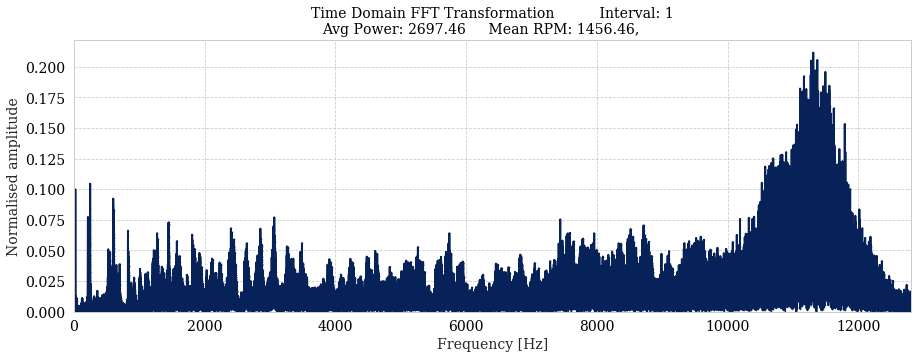

In [7]:
i = 1
plotting_methods.plot_fft(times[i], vib_signal[i], avg_power=avg_power[i], avg_rpm=avg_rpm[i], interval_num=i)

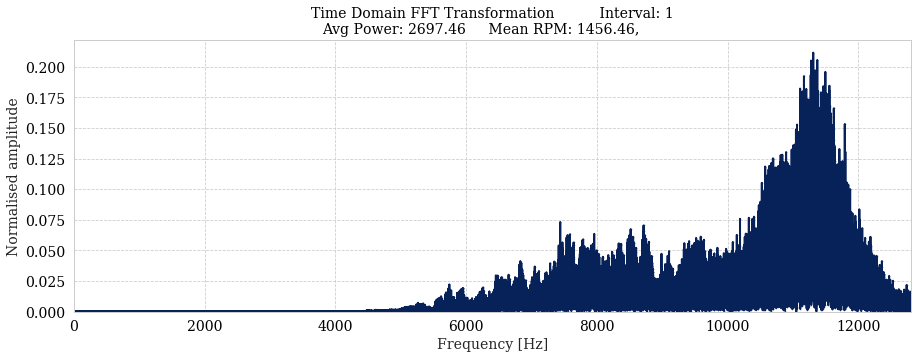

In [8]:
plotting_methods.plot_fft(times[i], filtered_raw_vib_6000[i], avg_power=avg_power[i], avg_rpm=avg_rpm[i], interval_num=i)


#### Save filtered, raw vibration signal to CSV

In [10]:

path = '/Volumes/OsvikExtra/signal_data/raw_filtered_6000Hz/gearbox/wt04/';
list_size = len(filtered_raw_vib_6000)
for i, vib_sig in enumerate(filtered_raw_vib_6000):
    np.savetxt(f'{path}filtered_raw_6000_{i}.csv', vib_sig, delimiter=',')
    print(f'Saved {i+1} / {list_size} files', end='\r')


## 2. Resampled signal

In [ ]:
# Linear Interpolation

time = times[0]
resampled_vib_signal = []
resampled_time_signal = []

for i, vib_sig in enumerate(vib_signal):
    resampled_round, resampled_y, resampled_time = resample_signals.do_linear_resampling(
        time, 
        vib_sig, 
        peak_array[i],
        number_of_resample_points=1500
    )
    
    resampled_time_signal.append(resampled_time)
    resampled_vib_signal.append(resampled_y)
    print(f'Resampled {i+1} / {vib_signal_size} signals', end='\r')

In [ ]:
i = 203
plotting_methods.plot_fft(resampled_time_signal[i], resampled_vib_signal[i], avg_power=avg_power[i], avg_rpm=avg_rpm[i], interval_num=i)

### 2.5 Filter out the first 2000 Hz

In [ ]:
low_cut = 2000
filtered_resampled_vib = []
resampled_vib_signal_size = len(resampled_vib_signal)

skip = 0
for i, vib_sig in enumerate(resampled_vib_signal):
    if len(vib_sig) < 100000:
        filtered_resampled_vib.append(vib_sig)
        skip +=1
        continue
    flitered_vib_sig = filter_signals.do_high_pass_filter(vib_sig, low_cut)
    filtered_resampled_vib.append(flitered_vib_sig)
    print(f'Filtered {i+1} / {resampled_vib_signal_size} resampled signals', end='\r')

In [ ]:
i = 0
plotting_methods.plot_fft(resampled_time_signal[i], filtered_resampled_vib[i], avg_power=avg_power[i], avg_rpm=avg_rpm[i], interval_num=i)

### Save filtered resampled vibration signal to CSV

In [ ]:
'''
path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/';
list_size = len(filtered_resampled_vib)
for i, vib_sig in enumerate(filtered_resampled_vib):
    time_and_vib = np.array([resampled_time_signal[i], vib_sig])
    time_and_vib_pd = pd.DataFrame(time_and_vib.T, columns=['Time', 'VibrationSignal'])
    time_and_vib_pd.to_csv(f'{path}filtered_resampled_{i}.csv', sep=',', header=time_and_vib_pd.columns)
    print(f'Saved {i+1} / {list_size} files', end='\r')
'''

## 3. Filtered signal with optimal bandpass based on SK

In [206]:
# Read kurtogram data
fc_and_bw_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/fc_and_bw_data.csv'
frequencies_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/frequencies.csv'
file_names_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/center_frequencies_&_bandwidth/file_name.txt'

fc_and_bw_path = f'../../../../../../signal_data/raw_filtered_6000Hz/gearbox/wt04/center_frequencies_&_bandwidth/fc_and_bw_data.csv'
frequencies_path = f'../../../../../../signal_data/raw_filtered_6000Hz/gearbox/wt04/center_frequencies_&_bandwidth/frequencies.csv'
file_names_path = f'../../../../../../signal_data/raw_filtered_6000Hz/gearbox/wt04/center_frequencies_&_bandwidth/file_name.txt'

fc_and_bw = pd.read_csv(fc_and_bw_path)
frequencies = pd.read_csv(frequencies_path)
file_names = pd.read_csv(file_names_path, header=None)

frequencies_numpy = np.asarray(frequencies).T
frequencies = pd.DataFrame(frequencies_numpy, columns= frequencies_numpy[0])
frequencies = frequencies.drop(frequencies.index[0]).reset_index(drop=True)
fc_and_bw

,File,Frequencies,Bandwidths
0,filtered_raw_6000_0.csv,9600.036621,6400.024414
1,filtered_raw_6000_1.csv,5975.022793,50.000191
2,filtered_raw_6000_10.csv,9600.036621,6400.024414
3,filtered_raw_6000_100.csv,9600.036621,6400.024414
4,filtered_raw_6000_101.csv,9600.036621,6400.024414
5,filtered_raw_6000_102.csv,8925.034046,50.000191
6,filtered_raw_6000_103.csv,8675.033093,50.000191
7,filtered_raw_6000_104.csv,5525.021076,50.000191
8,filtered_raw_6000_105.csv,9600.036621,6400.024414
9,filtered_raw_6000_106.csv,9600.036621,6400.024414


In [211]:
fc_bw_numpy = fc_and_bw.values.T
fc_bw_pd = pd.DataFrame(fc_bw_numpy, columns=fc_bw_numpy[0])
fc_bw_pd = fc_bw_pd.drop(fc_bw_pd.index[0])
fc_bw_pd.insert(0, 'RowName', ['Center Frequency', 'BandWidth'])

fc_bw_pd=fc_bw_pd.set_index('RowName') 



In [212]:
fc_bw_pd

,filtered_raw_6000_0.csv,filtered_raw_6000_1.csv,filtered_raw_6000_10.csv,filtered_raw_6000_100.csv,filtered_raw_6000_101.csv,filtered_raw_6000_102.csv,filtered_raw_6000_103.csv,filtered_raw_6000_104.csv,filtered_raw_6000_105.csv,filtered_raw_6000_106.csv,...,filtered_raw_6000_90.csv,filtered_raw_6000_91.csv,filtered_raw_6000_92.csv,filtered_raw_6000_93.csv,filtered_raw_6000_94.csv,filtered_raw_6000_95.csv,filtered_raw_6000_96.csv,filtered_raw_6000_97.csv,filtered_raw_6000_98.csv,filtered_raw_6000_99.csv
RowName,,,,,,,,,,,,,,,,,,,,,
Center Frequency,9600.04,5975.02,9600.04,9600.04,9600.04,8925.03,8675.03,5525.02,9600.04,9600.04,...,8775.03,5500.02,9375.04,8925.03,9600.04,12100,9600.04,9600.04,9125.03,9600.04
BandWidth,6400.02,50.0002,6400.02,6400.02,6400.02,50.0002,50.0002,50.0002,6400.02,6400.02,...,50.0002,66.6669,50.0002,50.0002,6400.02,66.6669,6400.02,6400.02,50.0002,6400.02


In [160]:
fc_bw_pd['filtered_resampled_0.csv'][0]

10376.016143860401

In [215]:
kurt_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/kurtograms/';
local_kurt_path = f"../../../../../../signal_data/raw_filtered_6000Hz/gearbox/wt04/kurtograms/"
save_path = f"../../../../../../signal_data/plots/kurtogram/wt04/raw_filtered_6000Hz/"

wt='wt04'
dir_size = len(os.listdir(local_kurt_path))
for i, filename in enumerate(os.listdir(local_kurt_path)):
    #if i > 1:
    #    break
    if filename.endswith('.csv'):
        kurt_file = f'{local_kurt_path}{filename}'
        kurtogram = pd.read_csv(kurt_file, header=None)
        
        frequency_filename = '_'.join(filename.split('_')[1:])
        
        max_SK = np.max(np.max(kurtogram))
        center_frequency = fc_bw_pd[frequency_filename][0]
        bandwidth = fc_bw_pd[frequency_filename][1]
        highest_window = np.argmax(kurtogram.max(axis=1))
        
        _ = plotting_methods.plot_kurtogram(kurtogram, 
                                        frequencies[frequency_filename], 
                                        file_name=frequency_filename,
                                        max_sk=max_SK,
                                        cf=center_frequency,
                                        bw=bandwidth,
                                        wt=wt,
                                        window=highest_window,
                                        save_path=save_path)

        print(f'Plot {i+1} / {dir_size} created', end='\r')


In [12]:
kurt_path = '/Volumes/OsvikExtra/signal_data/resampled_filtered_2000Hz/gearbox/wt04/kurtograms/';
kurt_file = f'{kurt_path}kgram_filtered_resampled_206.csv'
kurtogram = pd.read_csv(kurt_file, header=None)

In [200]:
%autoreload
plotting_methods

<module 'plotting_methods' from '/Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src/hybrid_analysis_process_functions/plotting_methods.py'>

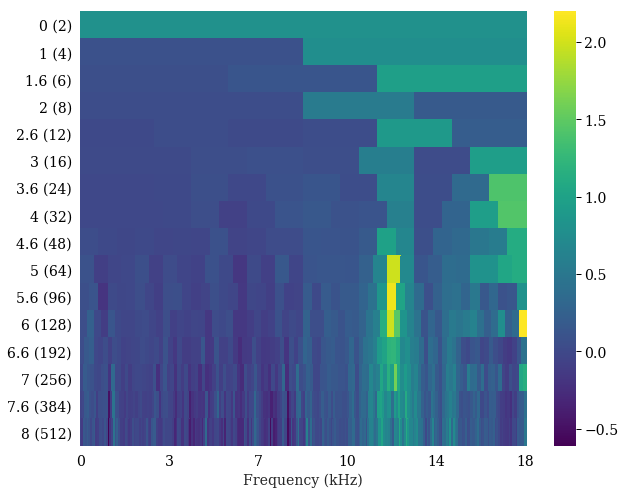

In [77]:
plotting_methods.plot_kurtogram(kurtogram, frequencies['filtered_resampled_206.csv'])

## 4. Demodulasation using EEMD signals

In [ ]:
from PyEMD import EEMD
import numpy as np
import pylab as plt
# Define signal
S = vib_signal[0][0:10000]
t = times[0][0:10000]

# Assign EEMD to `eemd` variable
eemd = EEMD()
# Say we want detect extrema using parabolic method
emd = eemd.EMD
emd.extrema_detection="parabol"
# Execute EEMD on S
eIMFs = eemd.eemd(S, t)
nIMFs = eIMFs.shape[0]
# Plot results
plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(t, S, 'r')


In [ ]:
envelope_emd.eemd('WT01',1,'gearbox',vib_signal[0][0:10000],times[0][0:10000],True)

## 5. Selecting IMF: Correlation coefficient

## 6. Envelope spectral analysis

## 7. Frequency study (fault characteristics), fault development